
# Aggregating vs averaging variant frequencies within groups
___

Load necessary packages and temperature experiment data file 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as sf
import matplotlib.pyplot as plt

In [2]:
from pi_for_temperature_notebook import *

In [3]:
data = pd.read_csv("variant-calls_temperature-expt_2020-04-07_tables.csv", header=0, index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The above errors can be ignored because they arise from 32$ ^{o} $ data, which we will filter out. Also filter out variants that are represented in only one technical replicate, as well as variants that do not have a frequency of 3% or more in at least one technical replicate.

In [4]:
data_no_32 = data.loc[data.temperature != 32]
data_no_32_both_present = data_no_32.dropna(subset=['ADReplicateA','ADReplicateB'])
filtered_data = pd.concat([data_no_32_both_present.loc[data_no_32_both_present.freqPropReplicateA >= 0.03],
                           data_no_32_both_present.loc[data_no_32_both_present.freqPropReplicateB >= 0.03]]).drop_duplicates()


Previous analyses has shown a tight correlation between technical replicates, as expected by the manner of the replication. Aggregate technical replicate read counts to get a single variant frequency for each sequence variant.

In [5]:
#set new DP and AD columns with aggregate of Replicate RD and AD values
#This aggregates only counts of reads that passed VarScan filters 
filtered_data['DP'] = filtered_data['ADReplicateA'] + filtered_data['ADReplicateB'] +filtered_data['RDReplicateA'] + filtered_data['RDReplicateB']
filtered_data['AD'] = filtered_data['ADReplicateA'] + filtered_data['ADReplicateB']

#calculate frequency of aggregated read counts
filtered_data['freqProp'] = filtered_data['AD'] / filtered_data['DP']


Add factor data for lineage, species, and segment (for DNA-A and DNA-B segment designations)

In [6]:
#lineage: set to 0 then assign each unique lineage to an unique integer
filtered_data['lineage_factor'] = 0
j = 0
for lineage in filtered_data.lineage.unique():
    filtered_data.loc[filtered_data.lineage == lineage,['lineage_factor']] = j
    j += 1

#species: Set ACMV = 0 and EACMCV = 1
filtered_data['species'] = 0
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-A',['species']] = 1
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-B',['species']] = 1

#segment: Set DNA-A = 0 and DNA-B = 1
filtered_data['segment'] = 0
filtered_data.loc[filtered_data.chrom == 'ACMV DNA-B',['segment']] = 1
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-B',['segment']] = 1


Load the options for calculation of pi then print them out.

In [7]:
options = get_temp_args()
#set new values for options as necessary
options['coverage'] = 'DP'
options['perSite'] = False

In [8]:
pis = {}

pi_df = get_group_pis(filtered_data,
                     options=options,
                     group_by=['passage','temperature','species','segment','lineage_factor','plantID'])

In [9]:
lm = sf.ols('pi ~ passage + temperature + (C(species)/C(segment)) + C(lineage_factor)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary2())

Least squares summary:
                      Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.299   
Dependent Variable:      pi                  AIC:                   267.5619
Date:                    2020-06-18 16:04    BIC:                   289.6088
No. Observations:        67                  Log-Likelihood:        -123.78 
Df Model:                9                   F-statistic:           32.79   
Df Residuals:            57                  Prob (F-statistic):    4.74e-20
R-squared:               0.394               Scale:                 2.7696  
----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------
Intercept                     -0.0178   0.1026 -0.1734 0.8623 -0.2188 0.1833
C(species)[T.1]               -0.6899   0.6951 -0.9926 0.3209 -2.0522 0.6724

There is strong multicollinearity in the model. Let's inspect a few variables

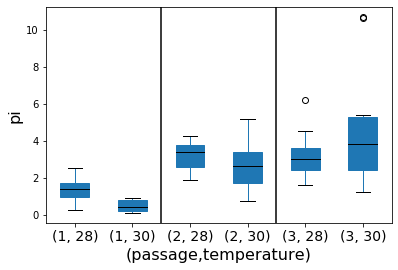

In [10]:
p = pi_df.boxplot(column='pi',
             by=['passage','temperature'],
             patch_artist=True,
             grid=False,
             return_type='dict')

plt.ylabel('pi',fontsize=16)
plt.xlabel('(passage,temperature)',fontsize=16)
ylim = plt.ylim()

plt.vlines(x=[2.5,4.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

plt.xticks(fontsize=14)
plt.suptitle('')
plt.title('')

for median in p[0]['medians']:
    median.set_color('k')

Looks like we could omit temperature from the model.

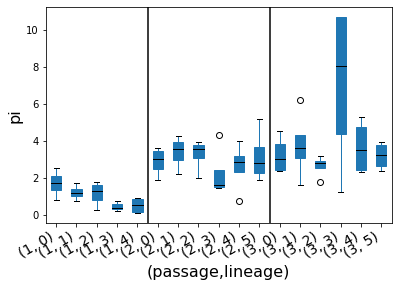

In [11]:
p = pi_df.boxplot(column='pi',
             by=['passage','lineage_factor'],
             patch_artist=True,
             grid=False,
             return_type='dict',
             rot=30)

plt.ylabel('pi',fontsize=16)
plt.xlabel('(passage,lineage)',fontsize=16)
ylim = plt.ylim()

plt.xticks(fontsize=14,ha='right')
plt.suptitle('')
plt.title('')

ylim = plt.ylim()

plt.vlines(x=[5.5,11.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

for median in p[0]['medians']:
    median.set_color('k')

Looks like we can onit lineage from the model as well.

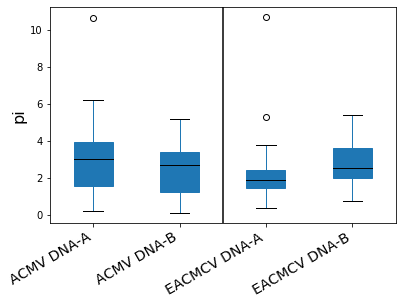

In [12]:
p = pi_df.boxplot(column='pi',
             by=['species','segment'],
             patch_artist=True,
             grid=False,
             return_type='dict',
             rot=30)

plt.ylabel('pi',fontsize=16)
plt.xlabel('',fontsize=16)
ylim = plt.ylim()

plt.vlines(x=[2.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

plt.xticks([1,2,3,4],
           ['ACMV DNA-A','ACMV DNA-B','EACMCV DNA-A','EACMCV DNA-B'],
           fontsize=14,
           ha='right')
plt.suptitle('')
plt.title('')

for median in p[0]['medians']:
    median.set_color('k')

Let's remove temperature and lineage from the model

In [13]:
lm = sf.ols('pi ~ passage + (C(species)/C(segment)) ',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())

Least squares summary:
                            OLS Regression Results                            
Dep. Variable:                     pi   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     10.05
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           2.46e-06
Time:                        16:04:44   Log-Likelihood:                -125.79
No. Observations:                  67   AIC:                             261.6
Df Residuals:                      62   BIC:                             272.6
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Looks like a moderate improvement gained by reducing variables. Let's aggregate the data to reduce noise.

In [14]:
agg_data = aggregate_groups(filtered_data,['species','segment','pos','alt','passage','ref'])

agg_data.reset_index(inplace=True)
agg_data['pos'] = agg_data.pos.astype(int)   

In [15]:
pi_df = get_group_pis(agg_data,
                     options=options,
                     group_by=['species','segment','passage'])

In [16]:
lm = sf.ols('pi ~ passage + C(species)/C(segment)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())

print("\nAnova table:")
table = sm.stats.anova_lm(lm)
print(table)
print("\n")
for ind in table.index:
    
    print("{} explains \t {:.2%} of variance".format(ind,table.loc[ind,'sum_sq'] / table.sum_sq.sum()))

Least squares summary:
                            OLS Regression Results                            
Dep. Variable:                     pi   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     15.01
Date:                Thu, 18 Jun 2020   Prob (F-statistic):            0.00152
Time:                        16:04:51   Log-Likelihood:                -32.232
No. Observations:                  12   AIC:                             74.46
Df Residuals:                       7   BIC:                             76.89
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


### Now let's look at averaging pi within groups

Let's start with the raw data again, and use the mean between technical replicates as a single frequency per variant. `freqPropMeanNoNA` already exists as the mean of ReplicateA and ReplicateB frequencies, so we can use `filtered_data` as-is. We'll first calculate pi from the average values and inspect the analysis results.

In [17]:
#set the frequency for column name of the mean of the replicates
options['frequency'] = 'freqPropMeanNoNA'

pi_df = get_group_pis(filtered_data,
                     options=options,
                     group_by=['passage','temperature','species','segment','lineage_factor','plantID'])

lm = sf.ols('pi ~ passage + temperature + (C(species)/C(segment)) + C(lineage_factor)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())

Least squares summary:
                            OLS Regression Results                            
Dep. Variable:                     pi   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     32.82
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           4.65e-20
Time:                        16:05:01   Log-Likelihood:                -123.72
No. Observations:                  67   AIC:                             267.4
Df Residuals:                      57   BIC:                             289.5
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Now plot data

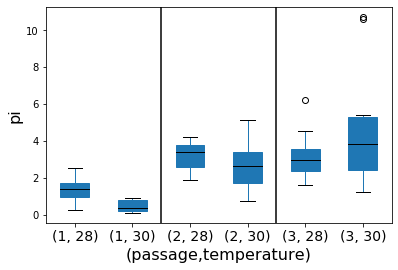

In [18]:
p = pi_df.boxplot(column='pi',
             by=['passage','temperature'],
             patch_artist=True,
             grid=False,
             return_type='dict')

plt.ylabel('pi',fontsize=16)
plt.xlabel('(passage,temperature)',fontsize=16)
ylim = plt.ylim()

plt.vlines(x=[2.5,4.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

plt.xticks(fontsize=14)
plt.suptitle('')
plt.title('')

for median in p[0]['medians']:
    median.set_color('k')

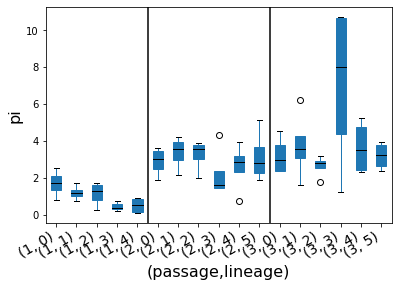

In [19]:
p = pi_df.boxplot(column='pi',
             by=['passage','lineage_factor'],
             patch_artist=True,
             grid=False,
             return_type='dict',
             rot=30)

plt.ylabel('pi',fontsize=16)
plt.xlabel('(passage,lineage)',fontsize=16)
ylim = plt.ylim()

plt.xticks(fontsize=14,ha='right')
plt.suptitle('')
plt.title('')

ylim = plt.ylim()

plt.vlines(x=[5.5,11.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

for median in p[0]['medians']:
    median.set_color('k')

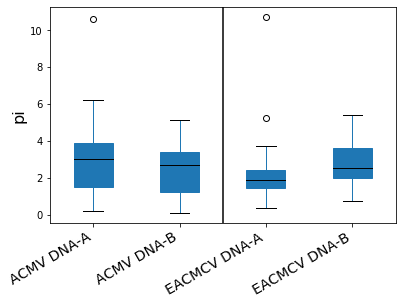

In [20]:
p = pi_df.boxplot(column='pi',
             by=['species','segment'],
             patch_artist=True,
             grid=False,
             return_type='dict',
             rot=30)

plt.ylabel('pi',fontsize=16)
plt.xlabel('',fontsize=16)
ylim = plt.ylim()

plt.vlines(x=[2.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

plt.xticks([1,2,3,4],
           ['ACMV DNA-A','ACMV DNA-B','EACMCV DNA-A','EACMCV DNA-B'],
           fontsize=14,
           ha='right')
plt.suptitle('')
plt.title('')

for median in p[0]['medians']:
    median.set_color('k')

Looks like there is no great difference in averaging or aggregating technical replicate data.

In [25]:
avg_data = average_groups(filtered_data,['species','segment','pos','alt','passage','ref'])

avg_data.reset_index(inplace=True)
avg_data['pos'] = avg_data.pos.astype(int)   


avg_pi_df = get_group_pis(agg_data,
                     options=options,
                     group_by=['species','segment','passage'])

In [26]:
lm_avg = sf.ols('pi ~ passage + C(species)/C(segment)',data=avg_pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm_avg.summary())

print("\nAnova table:")
table_avg = sm.stats.anova_lm(lm_avg)
print(table)

Least squares summary:
                            OLS Regression Results                            
Dep. Variable:                     pi   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     11.37
Date:                Thu, 18 Jun 2020   Prob (F-statistic):            0.00350
Time:                        16:06:11   Log-Likelihood:                -32.610
No. Observations:                  12   AIC:                             75.22
Df Residuals:                       7   BIC:                             77.64
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [27]:
print("Aggregated groups:")
for ind in table.index:
    
    print("{} \t\t {:.2%} of variance".format(ind,table.loc[ind,'sum_sq'] / table.sum_sq.sum()))

print("\nAveraged groups:")
for ind in table.index:
    
    print("{} \t\t {:.2%} of variance".format(ind,table_avg.loc[ind,'sum_sq'] / table_avg.sum_sq.sum()))

Aggregated groups:
C(species) 		 0.93% of variance
C(species):C(segment) 		 3.78% of variance
passage 		 77.47% of variance
Residual 		 17.82% of variance

Averaged groups:
C(species) 		 0.15% of variance
C(species):C(segment) 		 3.89% of variance
passage 		 76.54% of variance
Residual 		 19.42% of variance


### Looks there is not a great difference between averaging or aggregating technical replicate data. Also, removing temperature increases model performance. 
___
Not shown here: analyses running `linearmodels.PanelOLS` panel analyses on the temperature experiment fail when including both *temperature* and *passage* due to collinearity.  